# Natural Language Processings Methods (By Justin DUC)

## Summary

Here's a list of the topic that you'll a get broad view of today:

- Installation
- Reminder about AI optimization
- Embeddings & Word2Vec
- Seq2seq
- RNN/LSTM & limitations
- Attention & Transformers

## Installation

During this activity, we'll use torch's autograd in order to facilitate things. If you want to understand how auograds works and how to recreate one, don't hesitate to checkout POC's minitorch workshop.

If you are on archlinux, you can try to setup a virtual env ``python3 -m venv .venv`` and then select it in vscode on running.

In [5]:
!python3 -m pip install torch
!python3 -m pip install matplotlib
import torch as t
from embedding import Embedding, prepare_data
from rnn import RNN_CELL, prepare_data2, one_hot_to_vec, one_hot_to_word, word_to_vec

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Reminder about AI optimization

Okay, for those who didn't understand a day of the pool or have a fuzzy memory of it, here's a reminder about how ML optimisation generaly work with an example.

ML is basicly parameter optimization with the weights being the parameters. Most of the time, our goal is to optimise a model on a determined data. The selection of the data is very important and influence greatly the choice of the model but you'll see that in the next part.

A simple problem in ML is to find the best function to represent data automaticaly by relying on the mathematical principle of differentiation.

Partial differentiation at a specific point gives us the possibility to find how the parameter influence a result.

For example, $f(x) = 2x + 1$ should appear as such on a graph.

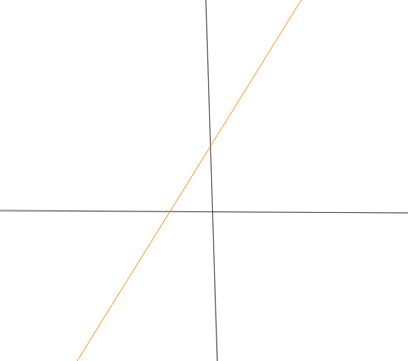

The partial derivative: ${\displaystyle {\frac {\partial f}{\partial x}}}$ would be 2 at any point because changing x change the function result by a factor of 2 time x where the ``+1`` is fixed.

Lets say we want our function to give us the following results with the following entries:

| Entry | Result |
|-|-|
|1|0.5|
|2|1.08|
|3|1.41|

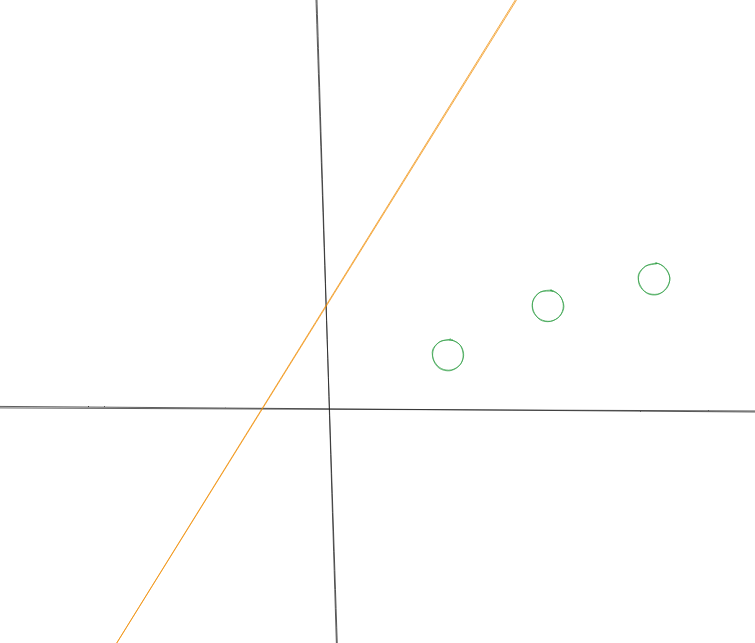

It looks like it is not doing its job very well! 😡

Some of you may have saw it but there is a solution to this problem that consist of the mean sum of the slopes but we are here to do ML so let optimize the function instead.

To optimise a function, we need a function to optimize (I mean thats pretty logical right?).
Lets set an objectif for the result to be the closest to 0.5, 1.08 and 1.41 for 1, 2 and 3 respectively. We could just evaluate if our result are close to our expected result with a MSELoss function: $\frac{1}{n} \sum_{i}^n(ypred_i - y_i)^2$
The better our function gives result, the lower the result of the MSELoss will be.
With our goal to minimise this MSELoss function,

By taking a Learning Rate: 0.01 (the learning rate is always inferior to 1 and 1 is most of the time not very good),
we can a calcul on the entries as a batch. (A random batch is good for generalising the neural network on the data)

In [1]:
import torch as t

batch_of_x  = t.tensor([1, 2, 3])
expected    = t.tensor([0.5, 1.08, 1.41])

epochs = 10

# ax + b = 2x + 1
a = t.tensor([2], dtype=t.float32, requires_grad=True)
b = t.tensor([1], dtype=t.float32, requires_grad=True)

optimizer = t.optim.SGD([a, b], lr=0.1)
loss = t.nn.MSELoss()

def f(x):
    return a * x + b

# we do the training ``epochs`` number of times
for i in range(epochs):
    
    res = f(batch_of_x)
    loss_result = loss(res, expected)

    optimizer.zero_grad()

    # this step calculate the derivative for our function with respect to x 
    loss_result.backward()

    # apply the derivative to the variable ``a`` with the learning rate (a = a - lr * partial_derivative_of_f_relative_to_a))
    optimizer.step()

    print(f(batch_of_x))

tensor([0.3920, 0.5847, 0.7773], grad_fn=<AddBackward0>)
tensor([0.6742, 1.0666, 1.4591], grad_fn=<AddBackward0>)
tensor([0.6405, 1.0133, 1.3862], grad_fn=<AddBackward0>)
tensor([0.6415, 1.0186, 1.3957], grad_fn=<AddBackward0>)
tensor([0.6387, 1.0174, 1.3962], grad_fn=<AddBackward0>)
tensor([0.6364, 1.0170, 1.3976], grad_fn=<AddBackward0>)
tensor([0.6342, 1.0165, 1.3989], grad_fn=<AddBackward0>)
tensor([0.6319, 1.0160, 1.4001], grad_fn=<AddBackward0>)
tensor([0.6298, 1.0156, 1.4014], grad_fn=<AddBackward0>)
tensor([0.6276, 1.0151, 1.4026], grad_fn=<AddBackward0>)


That was the basics of AI optimisation.

## Embeddings & Word2Vec

Data preparation and selection is often overlooked by many AI engineers when starting in the field. Its a massive error that many make and begin to understand as they further their comprehension.

Lets give you an example so you understand:

We would like to make a model that predict if the word has a Good/Bad inclination. Here's our data:

| Word | Prediction |
|-|-|
| awesome | Good |
| ugly | Bad |
| nice | Good |
| sad | Bad|

Most people would encode it arbitrarly using a index:

| Word | Encoding |
|-|-|
| awesome | 1 |
| ugly | 2 |
| nice | 3 |
| sad | 4 |

Our data would need 3 condition to be separated in a Classification Tree:

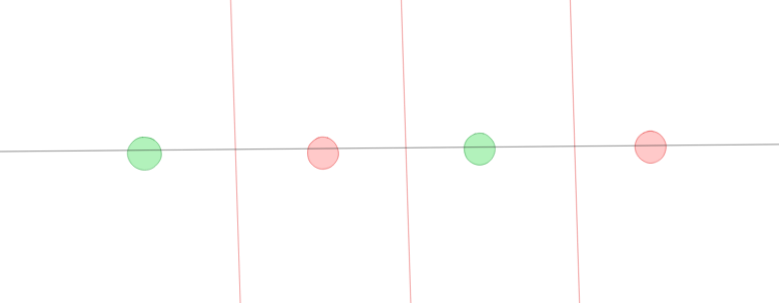

```shell
(w < 1.5)
|
| - > (w > 2.5)
|   |
|   | -> (w > 3.5)
|   |   |
|   |   | -> Bad
|   |   |
|   |   | -> Good
|   |
|   | -> Bad
|
| -> Good
```

Lets take a more meaningful representation by putting similar words close to each other to represent their meaning

| Word | Encoding |
| - | - |
| awesome | 1 |
| nice | 1.1 |
| ugly | 3 |
| sad | 4 |

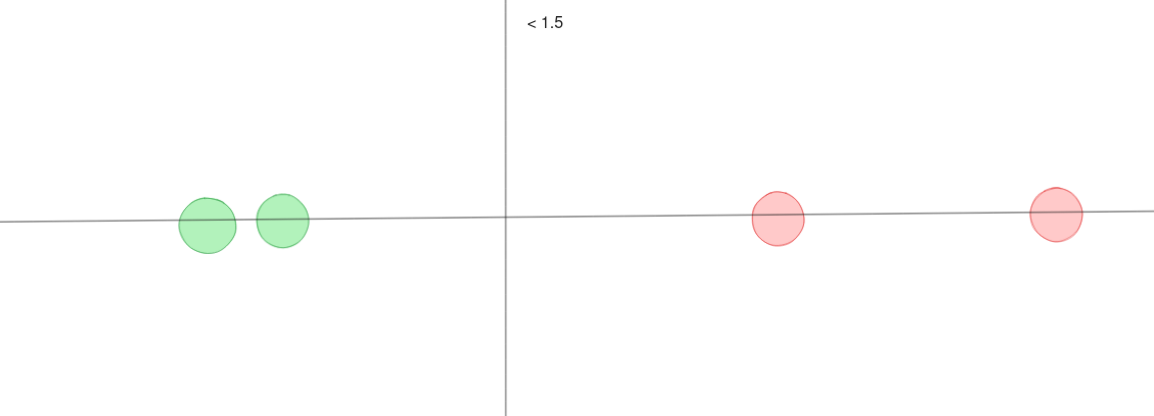

```shell
(w < 1.5)
|
| -> Good
|
| -> Bad
```

The solution is much simpler but we can't prepare the data by hand each time. Also, words meaning generaly can't be represented by only 1 variable.
Therefore we need a way to describe each variable by encoding it into vectors of numbers automaticaly.

Here comes the embeddings method. The idea is to train a neural network either to predict the next word in a seq of ``x`` words (x being the size of the embedding vectors) or to predict a word in the middle of seq of ``x`` words. These are respectively called **Skip-gram** and **Continuous bag of words**.
This neural networks would take a 1 hot-vector as an entry in order to easily pickout the vectors.

The goal of this network is to take a word and predict the next one. Its the Skip-gram model with 1 word.

Source:
*Disclaimer the values in the image are random and are only here as an example of how data flow through*
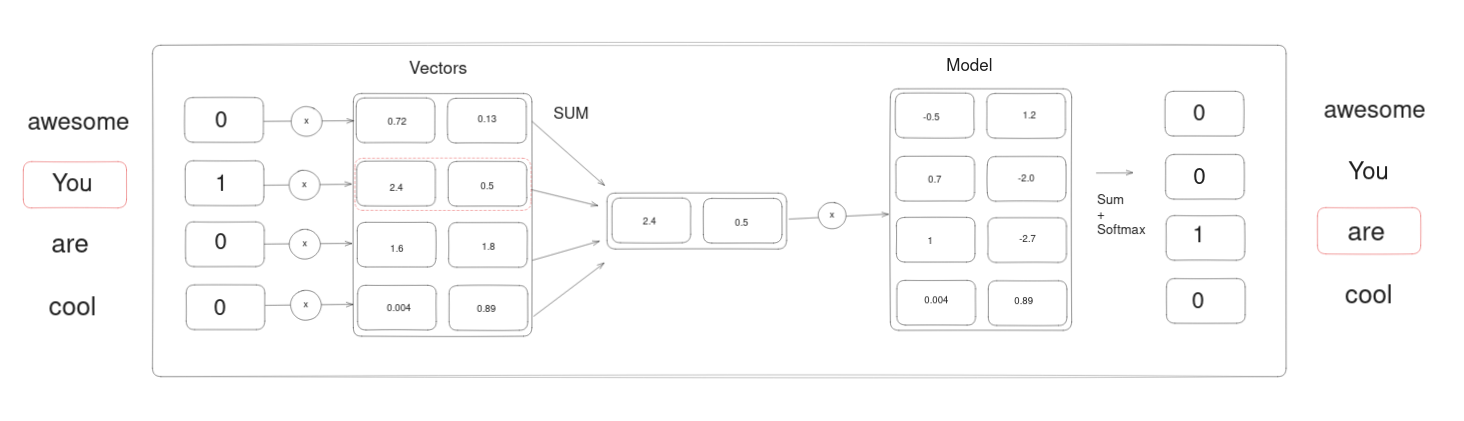

**Explanation**:
The red dots you can see on the image border is the vector that describe the word.

*Little reminder about softmax*: $\frac{\exp(X)}{\sum_i^n(\exp(X_i))}$.

It basicaly take a list of number and output a probability distribution of their importance adding up to 1.

This model train a 2 dimensional encoding of our data.
The bigger the dataset, the bigger the dictionnary and the bigger the precision of the encoding of the data. This is basicaly the concept of word2vec with the difference of word2vec having massive vectors of 1000 parameters and trained on something like wikipedia.

Let's code a little model


/home/ostentatoire/EpitechThirdYear/Transformers/embedding.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.__vectors)
/home/ostentatoire/EpitechThirdYear/Transformers/embedding.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  t.nn.init.xavier_normal(self.__model_weights)


0.0 epochs
0.01 epochs
0.02 epochs
0.03 epochs
0.04 epochs
0.05 epochs
0.06 epochs
0.07 epochs
0.08 epochs
0.09 epochs
0.1 epochs
0.11 epochs
0.12 epochs
0.13 epochs
0.14 epochs
0.15 epochs
0.16 epochs
0.17 epochs
0.18 epochs
0.19 epochs
0.2 epochs
0.21 epochs
0.22 epochs
0.23 epochs
0.24 epochs
0.25 epochs
0.26 epochs
0.27 epochs
0.28 epochs
0.29 epochs
0.3 epochs
0.31 epochs
0.32 epochs
0.33 epochs
0.34 epochs
0.35 epochs
0.36 epochs
0.37 epochs
0.38 epochs
0.39 epochs
0.4 epochs
0.41 epochs
0.42 epochs
0.43 epochs
0.44 epochs
0.45 epochs
0.46 epochs
0.47 epochs
0.48 epochs
0.49 epochs
0.5 epochs
0.51 epochs
0.52 epochs
0.53 epochs
0.54 epochs
0.55 epochs
0.56 epochs
0.57 epochs
0.58 epochs
0.59 epochs
0.6 epochs
0.61 epochs
0.62 epochs
0.63 epochs
0.64 epochs
0.65 epochs
0.66 epochs
0.67 epochs
0.68 epochs
0.69 epochs
0.7 epochs
0.71 epochs
0.72 epochs
0.73 epochs
0.74 epochs
0.75 epochs
0.76 epochs
0.77 epochs
0.78 epochs
0.79 epochs
0.8 epochs
0.81 epochs
0.82 epochs
0.83 epochs
0

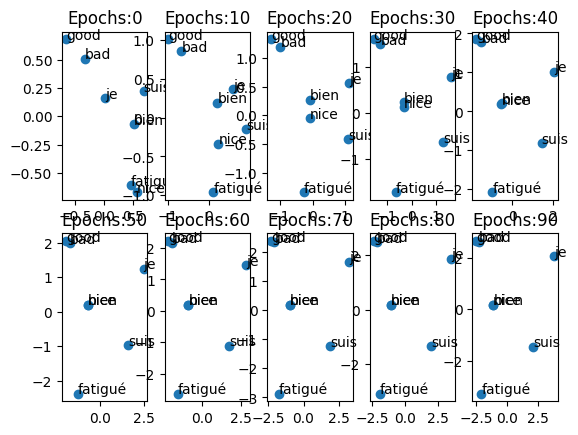

tensor([[-2.5981,  4.0505,  2.1670, -1.1808, -2.3799, -2.2401, -1.1814],
        [ 2.7441,  2.2050, -1.5229,  0.1839,  2.7134, -3.4062,  0.1840]],
       requires_grad=True)
{'good': 0, 'je': 1, 'suis': 2, 'bien': 3, 'bad': 4, 'fatigué': 5, 'nice': 6}


In [3]:
data, dictionnary = prepare_data("data")

embeddings = Embedding(len(dictionnary), 2)

embeddings.train(data, 100, dictionnary)

## Seq2seq

This part is an introduction to seq2seq processing and the stakes that comes with it.
For example, a sequence is like a sentence where each word would be a token.

Seq2seq is the idea of translating any sequence of token to another sequence. There is many types of models that includes: many to one, one to many and many to many.

The one we are interested in is the many to many as it includes the others.

#### Encoder-Decoder

Lets talk about architecture real quick.
In seq to seq models, you will often come across encoder-decoder architectures. The idea is scary at first but becomes more clear with time.

Encoders are suppose to get extract the meaning of the sequence given as entry and decoder are supposed to take this meaning and continue to generate until they generate a <EOS> token.

*Reminder: A EOS token means End Of Sequence. It's often used to detect when a decoder needs to stop.*

#### RNN

In 1982-1986, scientific papers on RNN appeared. They are purely mathematical as implementation was impossible at the time but they described a way to process sequence of tokens for related tasks.

The idea is pretty simple yet efficient. The idea is to use the same weights on all the inputs and pass information through to calculate a total context.

Let's do a little bit of math, shall we?

Lets say we consider our sequence of token as ${x_0, ..., x_t}$ where t is the number of tokens. ``t`` is often refered as a time step in research paper. A time step is basicly the $i^{th}$ element of the entry.

Then with $y_t$ being the prediction for the next token, $x_t$ being the token taken as entry (our embedding as seen previously), $W_{hh}$, $W_{hx}$, $W_{hy}$, $b_{hh}$, $b_{hx}$ and $b_{hy}$ being the weights and bias of the model and $h_t$ being the next context variable:

$h_t = tanh(h_{t-1} * W_{hh} + b_{hh} + x_t * W_{hx} + b_{hx})$

$y_t = softmax(h_t * W_{hy})$

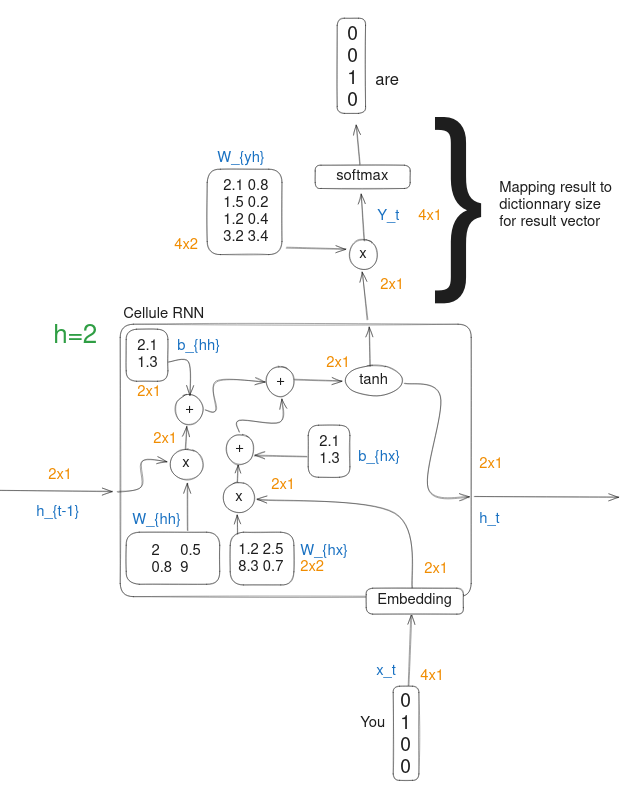

*Explanation:* The goal of the Weights $W_{hh}$, $W_{hx}$ and $W_{hy}$ and are the weight of the function our model needs to affine. The ``tanh`` function is an activation function. It has the particularity to keep the weights values close to 0 and make the classification more efficient before passing through the softmax.

#### Encoder Decoder RNN

Now the question is: How do we use this RNN Cell to make a seq2seq model?

A earlier section of this day talked about Encoder Decoder. Here's a schema of way we can use it:

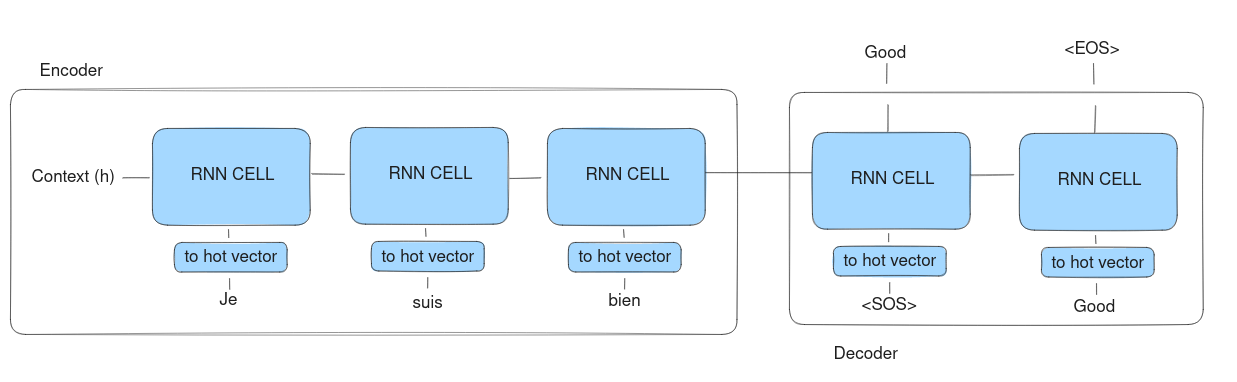

Let's quickly talk about the loss function. If we want to evaluate how far our model is from its best, we can just use a Mean Squared Error Loss (MSE Loss) on each output with the expected output and sum it all. Which would be represented by the following expression:

$\sum_{t=1}^{n}{MSELoss(output_{n}, expected\_output_{n})}$

With n being the number of outputs.

#### Problems with BPTT

BPTT means Backpropagation Through Time (Backpropagation through reccurent NN).

What we saw is great but there still is a problem with it. We need to consider that the gradient for each Weight is calculated as much time as there is outputs.

When optimising the result for each output, we calculate the impact each Weight had on the result and therefore their derivative. The problem is that the weights is shared and therefore if the derivative is low, it will get lower and lower because of the chain rule make it disappear. It can also encounter the inverse problem with the derivative exploding to infinity.

Furthermore, the network will be prompt to forgeting information as the sequence to encode get bigger.

#### LSTMs

Long Time Short Time memory cells, or LSTM Cells for short, are meant to fix exactly this problem. The idea is to have a second context that is meant to decide which data to conserve. It is still a reccurent model and therefore not efficient for parallelized training.
If you want to want more about LSTMs, I advise you to look at the Stat Quest video about it: https://www.youtube.com/watch?v=YCzL96nL7j0

#### Parallelizable Seq2seq

The usefulness of parllelizable models is unmatched. Basicly in RNNs we need some data to calculate other data. This is what creates the problem of exploding and erasing gradients. To avoid that, people thought about using CNNs to compute sequences which is quite smart (check out Convs2s if you are interested).

However, there is still problems with scalability with such models which brings us to the next subject: Transformers.

But before that, checkout this RNN_CELL made by hand:


In [6]:
dataset, dictionnary = prepare_data2("data")
t.autograd.set_detect_anomaly(True)

# Sizes
entry_size = 2
hidden_size = 4
output_size = len(dictionnary)

# Traning paramter
epochs  = 10
lr      = 0.01

# Model & training tools
model = RNN_CELL(hidden_size, entry_size)
w_yh = t.empty(output_size, hidden_size, requires_grad=True)
t.nn.init.xavier_uniform_(w_yh)
optimizer = t.optim.Adam(model.weights + [w_yh], lr)
loss_fct = t.nn.MSELoss()

for i in range(epochs):

    #  The context is reinitialised each time
    avg_loss = 0
    for seq, y in dataset:

        optimizer.zero_grad()
        context = t.zeros(hidden_size, 1)

        # encode the entry
        for token in seq:
            context = model(context, one_hot_to_vec(token).unsqueeze(1))

        # decode
        context = model(context, word_to_vec("<sos>").unsqueeze(1))
        res = t.matmul(w_yh, context)

        loss = loss_fct(res, y.unsqueeze(1))
        avg_loss += loss.item()
        loss.backward(retain_graph=True)

        optimizer.step()

    print("Avg_loss:", avg_loss / len(dataset))


# test
for seq, y in dataset:

    context = t.zeros(hidden_size, 1)

    # encode the entry
    for token in seq:
        print(one_hot_to_word(token), end=" ")
        context = model(context, one_hot_to_vec(token).unsqueeze(1))

    context = model(context, word_to_vec("<sos>").unsqueeze(1))
    print(one_hot_to_word(t.matmul(w_yh, context)))

Avg_loss: 0.28634310762087506
Avg_loss: 0.1934702768921852
Avg_loss: 0.13469126323858896
Avg_loss: 0.09825978179772694
Avg_loss: 0.07393896641830604
Avg_loss: 0.056760589281717934
Avg_loss: 0.04508272185921669
Avg_loss: 0.03662707842886448
Avg_loss: 0.0294957064713041
Avg_loss: 0.023259622665743034
je suis bien good
je suis fatigué bad
je suis nice good


## Self Attention and Transformers

Attention in NLP is a concept about linking tokens with each other. Its very useful for words to establish link with on another.

A Transformer Layer is usually composed of two parts:
- Self Attention / Multihead Attention
- MLP (Multilayer perceptron)

The entry taken by this model layer are embeddings. But before fedding the embeddings to the network, we need to encode the position of the word into it.

#### Positional Encoding

Positional Encoding is a way to give the network a knowlegde of where the token is in the computed sequence. For example:

"The dog killed the man" isn't the same as "The man killed the dog"

So, PE, or Positional Encoding, is made by using this formula:

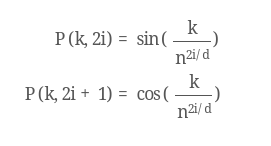 

Where:

*k*: Position of an object in the input sequence,

*d*: Dimension of the output embedding space

*P(k, j)*: Position function for mapping a position in the input sequence to index
of the positional matrix

*n*: User-defined scalar, set to 10,000 by the authors of Attention Is All You Need.

*i*: Used for mapping to column indices , with a single value of maps to both sine and cosine functions

Here's an example:

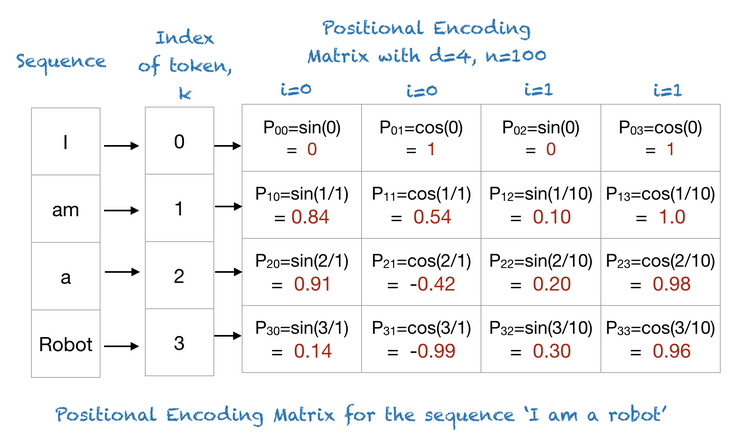

If you want more explanation about it, take a look at the **source** material of the images: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/.

#### Attention

Now that we have our entry, we need to generate a data that represent our word in the sentence and also generate data the represent all the other tokens.

The data that represent the token we are computing is called the Query ($Q$) and the data representing the data of each tokens is called the key ($K$).

The idea is to generate the data from the Weights $W_k$ and $W_q$.

Then, with our embedding $E(x)$, X as our set of tokens ${x_0, x_1, ..., x_n}$, n being the number of token to consider in the encoding input:

$Ed = PE(E_d(x_t))$

$Q_t = W_q * Ed$

$K = W_k * X$

$P_t = softmax(Q_t * K)$

$P_t$ represent how much of each data the network will keep to predict the next word. Therefore, $P_t$ is the distribution function of the attention.

Then we just need to multiply the embdedding of each tokens $E(X)$ by the amount of the data that should be kept $P_t$ and then sum all the values so that the output is of the same dimension as E(x).

$AttentionValues = sum(E(X) * P_t, dim=1)$

What we have done is called a single head attention. Models usualy use more heads. The original paper (Attention is all you need) used 8 attention heads. It just means that it applied this process for 8 diffenrents weights meaning we get 8 $AttentionValues$.

Heres a little schema from the StatQuest Transformer video:

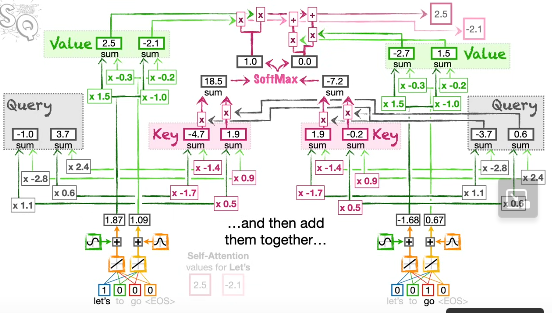

#### Residual Connection

Once we have calculated the attention values, it will be very difficult for the network to know the token thats being worked. To fix that problem, we then add the PE values to the AttentionValues.

#### Decoder

Once its done for each data in the sequence to encode, we finished with the encoder.

The decoder basicly use the same logic have a second layer that take all the AttentionValues from the encoder as entry for the new Attention layer:

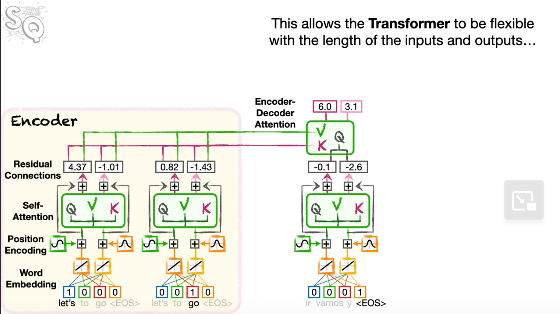

Once the Attention Values for the Decoder have been calculated, we can use them to predict the tokens.


#### MLP

A simple MLP transformation and a softmax is enough to extract the prediction of the network.

A MLP as a reminder is a basic Matrix multiplication.


#### Conclusion

NLP & Seq2seq task are still evoluating and the most recent model discussed today was out in 2017 (7 years ago already) and have seen many evolutions. There is still a lot of room for improvement in the field.